### This is a new version of MLEAP scripts, started in late Aug 2022.
It will combine IProject_MLEAP_ANN and IP_MLEAP script, while improving them.

#### Outline

1. Load libraries and data.
2. pEDA. Look at feature distribution, fix them if they do not look right.
3. Train-test split. Most likely couple years into test set. 2015-2018?. Impute missing values.
4. Transform numerical features, add ohe for inds.
5. Fit xgb as a baseline, then xgb optuna.
6. Fit DL.



In [1]:
# 0. Import libraries #

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import os, time, math, re, warnings, random, gc, dill, optuna, pickle, shap
import statsmodels.api as sm
from random import sample

from sklearn.model_selection import train_test_split, KFold, PredefinedSplit
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNetCV
from sklearn.preprocessing import LabelBinarizer, LabelEncoder, OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.inspection import permutation_importance
from category_encoders import MEstimateEncoder
from xgboost import XGBRegressor
from optuna.integration import TFKerasPruningCallback
from optuna.trial import TrialState

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers

plt.style.use('seaborn-white')
warnings.simplefilter(action='ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING)
pd.set_option('display.max_columns', 150)
gc.enable()

In [2]:
### target encoding ###
# source: https://www.kaggle.com/code/ryanholbrook/feature-engineering-for-house-prices/notebook

class CrossFoldEncoder:
    def __init__(self, encoder, **kwargs):
        self.encoder_ = encoder
        self.kwargs_ = kwargs  # keyword arguments for the encoder
        self.cv_ = KFold(n_splits=4)

    # Fit an encoder on one split and transform the feature on the
    # other. Iterating over the splits in all folds gives a complete
    # transformation. We also now have one trained encoder on each
    # fold.
    def fit_transform(self, X, y, cols):
        self.fitted_encoders_ = []
        self.cols_ = cols
        X_encoded = []
        for idx_encode, idx_train in self.cv_.split(X):
            fitted_encoder = self.encoder_(cols=cols, **self.kwargs_)
            fitted_encoder.fit(
                X.iloc[idx_encode, :], y.iloc[idx_encode],
            )
            X_encoded.append(fitted_encoder.transform(X.iloc[idx_train, :])[cols])
            self.fitted_encoders_.append(fitted_encoder)
        X_encoded = pd.concat(X_encoded)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded

    # To transform the test data, average the encodings learned from
    # each fold.
    def transform(self, X):
        from functools import reduce

        X_encoded_list = []
        for fitted_encoder in self.fitted_encoders_:
            X_encoded = fitted_encoder.transform(X)
            X_encoded_list.append(X_encoded[self.cols_])
        X_encoded = reduce(
            lambda x, y: x.add(y, fill_value=0), X_encoded_list
        ) / len(X_encoded_list)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded

In [3]:
# Detect TPU, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() 
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() 

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [4]:
# Functions for Optuna NNs

cv_nn_regularizer = 0.2

def create_snnn4_model_hyperpars(neurons_base=4, l1_reg_rate=0.1, l2_reg_rate=0.1):

    model_snn = Sequential([
        tf.keras.layers.Dense(units=neurons_base*4, activation="selu", kernel_initializer="lecun_normal", 
                              kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_reg_rate, l2=l2_reg_rate), 
                              input_shape=X_train.shape[1:]),
        tf.keras.layers.Dense(units=neurons_base*2, activation="selu", kernel_initializer="lecun_normal",
                             kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_reg_rate, l2=l2_reg_rate)),
        tf.keras.layers.Dense(units=neurons_base, activation="selu", kernel_initializer="lecun_normal",
                             kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_reg_rate, l2=l2_reg_rate)),
        tf.keras.layers.Dense(units=neurons_base/2, activation="selu", kernel_initializer="lecun_normal",
                             kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_reg_rate, l2=l2_reg_rate)),
        Dense(1)])

    optimizer_adam = tf.keras.optimizers.Adam()
    model_snn.compile(loss= "mean_squared_error" , optimizer=optimizer_adam, metrics=["mean_squared_error"])
    
    return model_snn

def create_snnn4_model(trial):

    # hyperparameter space
    neurons_base = trial.suggest_int("neurons_base", 4, 24, 2)
    l2_reg_rate = trial.suggest_float('l2_regularizer', 0, 0.9)
    l1_reg_rate = trial.suggest_float('l1_regularizer', 0, 0.9)

    model_snn = Sequential([
        tf.keras.layers.Dense(units=neurons_base*4, activation="selu", kernel_initializer="lecun_normal", 
                              kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_reg_rate, l2=l2_reg_rate), 
                              input_shape=X_train.shape[1:]),
        tf.keras.layers.Dense(units=neurons_base*2, activation="selu", kernel_initializer="lecun_normal",
                             kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_reg_rate, l2=l2_reg_rate)),
        tf.keras.layers.Dense(units=neurons_base, activation="selu", kernel_initializer="lecun_normal",
                             kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_reg_rate, l2=l2_reg_rate)),
        tf.keras.layers.Dense(units=neurons_base/2, activation="selu", kernel_initializer="lecun_normal",
                             kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_reg_rate, l2=l2_reg_rate)),
        Dense(1)])

    optimizer_adam = tf.keras.optimizers.Adam()
    model_snn.compile(loss= "mean_squared_error" , optimizer=optimizer_adam, metrics=["mean_squared_error"])
    
    return model_snn


def create_snnn6_model_hyperpars(neurons_base=4, l1_reg_rate=0.1, l2_reg_rate=0.1):

    model_snn = Sequential([
        tf.keras.layers.Dense(units=neurons_base*4, activation="selu", kernel_initializer="lecun_normal", 
                              kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_reg_rate, l2=l2_reg_rate), 
                              input_shape=X_train.shape[1:]),
        tf.keras.layers.Dense(units=neurons_base*2, activation="selu", kernel_initializer="lecun_normal",
                             kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_reg_rate, l2=l2_reg_rate)),
        tf.keras.layers.Dense(units=neurons_base*2, activation="selu", kernel_initializer="lecun_normal",
                             kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_reg_rate, l2=l2_reg_rate)),
        tf.keras.layers.Dense(units=neurons_base, activation="selu", kernel_initializer="lecun_normal",
                             kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_reg_rate, l2=l2_reg_rate)),
        tf.keras.layers.Dense(units=neurons_base, activation="selu", kernel_initializer="lecun_normal",
                             kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_reg_rate, l2=l2_reg_rate)),
        tf.keras.layers.Dense(units=neurons_base/2, activation="selu", kernel_initializer="lecun_normal",
                             kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_reg_rate, l2=l2_reg_rate)),
        Dense(1)])

    optimizer_adam = tf.keras.optimizers.Adam()
    model_snn.compile(loss= "mean_squared_error" , optimizer=optimizer_adam, metrics=["mean_squared_error"])
    
    return model_snn

def create_snnn6_model(trial):

    # hyperparameter space
    neurons_base = trial.suggest_int("neurons_base", 4, 24, 2)
    l2_reg_rate = trial.suggest_float('l2_regularizer', 0, 0.9)
    l1_reg_rate = trial.suggest_float('l1_regularizer', 0, 0.9)

    model_snn = Sequential([
        tf.keras.layers.Dense(units=neurons_base*4, activation="selu", kernel_initializer="lecun_normal", 
                              kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_reg_rate, l2=l2_reg_rate), 
                              input_shape=X_train.shape[1:]),
        tf.keras.layers.Dense(units=neurons_base*2, activation="selu", kernel_initializer="lecun_normal",
                             kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_reg_rate, l2=l2_reg_rate)),
        tf.keras.layers.Dense(units=neurons_base*2, activation="selu", kernel_initializer="lecun_normal",
                             kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_reg_rate, l2=l2_reg_rate)),
        tf.keras.layers.Dense(units=neurons_base, activation="selu", kernel_initializer="lecun_normal",
                             kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_reg_rate, l2=l2_reg_rate)),
        tf.keras.layers.Dense(units=neurons_base, activation="selu", kernel_initializer="lecun_normal",
                             kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_reg_rate, l2=l2_reg_rate)),
        tf.keras.layers.Dense(units=neurons_base/2, activation="selu", kernel_initializer="lecun_normal",
                             kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_reg_rate, l2=l2_reg_rate)),
        Dense(1)])

    optimizer_adam = tf.keras.optimizers.Adam()
    model_snn.compile(loss= "mean_squared_error" , optimizer=optimizer_adam, metrics=["mean_squared_error"])
    
    return model_snn


def objective_nn4(trial):
    
    tf.keras.backend.clear_session()
    
    with strategy.scope():
        # Generate our trial model.
        model = create_snnn4_model(trial)

        callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=40),
        TFKerasPruningCallback(trial, "val_loss"),
    ]

        # Fit the model on the training data.
        # The TFKerasPruningCallback checks for pruning condition every epoch.
        
        history = model.fit(X_train, y_train, 
                                validation_data=(X_val, y_val),
                                batch_size=2048, 
                                epochs=500, 
                                verbose=0, 
                                callbacks=callbacks)

        # Evaluate the model accuracy on the validation set.
        loss_train = model.evaluate(X_train, y_train, verbose=0)
        loss_val = model.evaluate(X_val_extra, y_val_extra, verbose=0)
        overfit = max(loss_val[1]-loss_train[1], 0)
        return loss_val[1] + cv_nn_regularizer*overfit
    
    
def objective_nn6(trial):
    
    tf.keras.backend.clear_session()
    
    with strategy.scope():
        # Generate our trial model.
        model = create_snnn6_model(trial)

        callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=40),
        TFKerasPruningCallback(trial, "val_loss"),
    ]

        # Fit the model on the training data.
        # The TFKerasPruningCallback checks for pruning condition every epoch.
        
        history = model.fit(X_train, y_train, 
                                validation_data=(X_val, y_val),
                                batch_size=2048, 
                                epochs=500, 
                                verbose=0, 
                                callbacks=callbacks)

        # Evaluate the model accuracy on the validation set.
        loss_train = model.evaluate(X_train, y_train, verbose=0)
        loss_val = model.evaluate(X_val_extra, y_val_extra, verbose=0)
        overfit = max(loss_val[1]-loss_train[1], 0)
        return loss_val[1] + cv_nn_regularizer*overfit


(28169, 41)

(3183, 41)

(3148, 41)

Number of features before transformation:  (28169, 38)
time to do feature proprocessing: 
Number of features after transformation:  (28169, 81) (3183, 81) (3135, 81) (3148, 81)
mae of a constant model 7.449410744523996
R2 of a constant model 0.0
fixed XGB train: 6.6404244439331155 0.20367387585733154
XGB val: 6.95041177187386 0.03588288720911759
XGB val extra: 7.6742518198770515 -0.025265240467944095
XGB test: 7.666935429587563 -0.011350303327938294
gs XGB {'colsample_bytree': 0.6, 'eta': 0.02, 'max_depth': 3, 'n_estimators': 800, 'subsample': 0.6} 0.04028216208954838 44.98599648475647
XGB train: 6.654836492171592 0.19714418801403566
XGB validation: 6.658730609524091 0.11395073365489594
XGB validation extra: 7.2109727702120345 0.09519933541519099
XGB test: 7.497737377821732 0.015670922109296548
Total time for hypermarameter optimization  48.56606984138489
        n_estimators : 965
           max_depth : 3
       learning_rate : 0.02642865529494576
    colsample_bytree : 0.073311168825

2022-09-08 22:15:33.160166: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-08 22:15:33.161487: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-08 22:15:33.162278: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-08 22:15:33.163285: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

3673


2022-09-08 22:15:40.499609: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Minimum Validation Loss: 86.3159
2897
Minimum Validation Loss: 83.8077
3329
Minimum Validation Loss: 84.6118


'Optuna NN4'

{'neurons_base': 14,
 'l2_regularizer': 0.18288034327872169,
 'l1_regularizer': 0.8389372829019411}

349.6376030445099

[14, 0.18288034327872169, 0.8389372829019411]

349.6475212574005 [14, 0.18288034327872169, 0.8389372829019411]


'Optuna NN6'

{'neurons_base': 24,
 'l2_regularizer': 0.5094272246716076,
 'l1_regularizer': 0.5125859415860495}

286.2757682800293

[24, 0.5094272246716076, 0.5125859415860495]

286.2833926677704 [24, 0.5094272246716076, 0.5125859415860495]


,min_prd,xgbf_train,xgbf_val,xgbf_test,xgbgs_train,xgbgs_val,xgbgs_test,xgbo_train,xgbo_val,xgbo_test,nn2_train,nn2_val,nn2_test,nn4_train,nn4_val,nn4_test,nn6_train,nn6_val,nn6_test,nn4opt_train,nn4opt_val,nn4opt_test,nn6opt_train,nn6opt_val,nn6opt_test
0,100,0.203674,0.035883,-0.01135,0.197144,0.113951,0.015671,0.192426,0.116482,0.0163,0.187214,0.050279,-0.026719,0.175113,0.053136,-0.0223,0.167318,0.063238,-0.013482,-0.0,-0.000984,-0.000895,-0.000001,-0.00097,-0.000882
1,160,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,220,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(49790, 41)

(4626, 41)

(4564, 41)

Number of features before transformation:  (49790, 38)
time to do feature proprocessing: 
Number of features after transformation:  (49790, 84) (4626, 84) (4467, 84) (4564, 84)
mae of a constant model 8.543293031215802
R2 of a constant model 0.0
fixed XGB train: 7.554798795623757 0.09287854395714357
XGB val: 8.155346117415649 0.059217993051724704
XGB val extra: 11.481561495779207 0.008107642963621764
XGB test: 10.597375953591559 0.019307149263134482
gs XGB {'colsample_bytree': 0.6, 'eta': 0.02, 'max_depth': 3, 'n_estimators': 800, 'subsample': 0.6} 0.06484049805573822 51.66467547416687
XGB train: 7.591178027944776 0.0835461159391857
XGB validation: 8.0085812097582 0.10412380609102212
XGB validation extra: 11.04377143915742 0.09820444447955856
XGB test: 10.748917824610945 0.001780168638554569
Total time for hypermarameter optimization  82.62882447242737
        n_estimators : 966
           max_depth : 2
       learning_rate : 0.02548580888077218
    colsample_bytree : 0.414896595468608

'Optuna NN4'

{'neurons_base': 18,
 'l2_regularizer': 0.15225154332593377,
 'l1_regularizer': 0.10704773911322807}

373.79565834999084

[18, 0.15225154332593377, 0.10704773911322807]

373.8040773868561 [18, 0.15225154332593377, 0.10704773911322807]


'Optuna NN6'

{'neurons_base': 22,
 'l2_regularizer': 0.34838490839364916,
 'l1_regularizer': 0.11162292631928182}

449.37172770500183

[22, 0.34838490839364916, 0.11162292631928182]

449.37922716140747 [22, 0.34838490839364916, 0.11162292631928182]


,min_prd,xgbf_train,xgbf_val,xgbf_test,xgbgs_train,xgbgs_val,xgbgs_test,xgbo_train,xgbo_val,xgbo_test,nn2_train,nn2_val,nn2_test,nn4_train,nn4_val,nn4_test,nn6_train,nn6_val,nn6_test,nn4opt_train,nn4opt_val,nn4opt_test,nn6opt_train,nn6opt_val,nn6opt_test
0,100,0.203674,0.035883,-0.01135,0.197144,0.113951,0.015671,0.192426,0.116482,0.0163,0.187214,0.050279,-0.026719,0.175113,0.053136,-0.0223,0.167318,0.063238,-0.013482,-0.0,-0.000984,-0.000895,-0.000001,-0.00097,-0.000882
1,160,0.092879,0.059218,0.019307,0.083546,0.104124,0.00178,0.069334,0.094531,0.043318,0.074393,0.067285,0.003229,0.068968,0.073971,0.014049,0.052757,0.072847,0.020005,0.052429,0.061237,0.040007,0.053314,0.065534,0.03404
2,220,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(78777, 41)

(6776, 41)

(6725, 41)

Number of features before transformation:  (78777, 38)
time to do feature proprocessing: 
Number of features after transformation:  (78777, 85) (6776, 85) (6626, 85) (6725, 85)
mae of a constant model 7.95324650764518
R2 of a constant model 0.0
fixed XGB train: 7.461524455202487 0.06941230429324552
XGB val: 7.545997375000349 0.03352923363258653
XGB val extra: 9.067902321717076 0.03326771380649873
XGB test: 8.511134003884694 0.050883922877477894
gs XGB {'colsample_bytree': 0.6, 'eta': 0.02, 'max_depth': 4, 'n_estimators': 800, 'subsample': 0.6} 0.036690922773572776 59.65374279022217
XGB train: 7.37817013229899 0.09630538200710714
XGB validation: 7.335220163326625 0.09019016883303754
XGB validation extra: 8.796641457324553 0.0999231529658946
XGB test: 8.409557751581776 0.06939455058495159
Total time for hypermarameter optimization  112.35638976097107
        n_estimators : 1248
           max_depth : 2
       learning_rate : 0.02994790616107911
    colsample_bytree : 0.39404782637881713


'Optuna NN4'

{'neurons_base': 16,
 'l2_regularizer': 0.40452567027612496,
 'l1_regularizer': 0.13313391182357334}

493.5750524997711

[16, 0.40452567027612496, 0.13313391182357334]

493.58376121520996 [16, 0.40452567027612496, 0.13313391182357334]


'Optuna NN6'

{'neurons_base': 16,
 'l2_regularizer': 0.026970846191440346,
 'l1_regularizer': 0.18104192814188844}

486.8481533527374

[16, 0.026970846191440346, 0.18104192814188844]

486.8577973842621 [16, 0.026970846191440346, 0.18104192814188844]


,min_prd,xgbf_train,xgbf_val,xgbf_test,xgbgs_train,xgbgs_val,xgbgs_test,xgbo_train,xgbo_val,xgbo_test,nn2_train,nn2_val,nn2_test,nn4_train,nn4_val,nn4_test,nn6_train,nn6_val,nn6_test,nn4opt_train,nn4opt_val,nn4opt_test,nn6opt_train,nn6opt_val,nn6opt_test
0,100,0.203674,0.035883,-0.01135,0.197144,0.113951,0.015671,0.192426,0.116482,0.0163,0.187214,0.050279,-0.026719,0.175113,0.053136,-0.0223,0.167318,0.063238,-0.013482,-0.0,-0.000984,-0.000895,-0.000001,-0.00097,-0.000882
1,160,0.092879,0.059218,0.019307,0.083546,0.104124,0.00178,0.069334,0.094531,0.043318,0.074393,0.067285,0.003229,0.068968,0.073971,0.014049,0.052757,0.072847,0.020005,0.052429,0.061237,0.040007,0.053314,0.065534,0.03404
2,220,0.069412,0.033529,0.050884,0.096305,0.09019,0.069395,0.061315,0.056884,0.061644,0.052126,0.042961,0.065112,0.048615,0.045624,0.066773,0.052574,0.044493,0.061762,-0.000001,-0.000327,-0.000351,0.044841,0.039103,0.056128


,min_prd,xgbf_train,xgbf_val,xgbf_test,xgbgs_train,xgbgs_val,xgbgs_test,xgbo_train,xgbo_val,xgbo_test,nn2_train,nn2_val,nn2_test,nn4_train,nn4_val,nn4_test,nn6_train,nn6_val,nn6_test,nn4opt_train,nn4opt_val,nn4opt_test,nn6opt_train,nn6opt_val,nn6opt_test
0,100,0.203674,0.035883,-0.01135,0.197144,0.113951,0.015671,0.192426,0.116482,0.0163,0.187214,0.050279,-0.026719,0.175113,0.053136,-0.0223,0.167318,0.063238,-0.013482,-0.0,-0.000984,-0.000895,-0.000001,-0.00097,-0.000882
1,160,0.092879,0.059218,0.019307,0.083546,0.104124,0.00178,0.069334,0.094531,0.043318,0.074393,0.067285,0.003229,0.068968,0.073971,0.014049,0.052757,0.072847,0.020005,0.052429,0.061237,0.040007,0.053314,0.065534,0.03404
2,220,0.069412,0.033529,0.050884,0.096305,0.09019,0.069395,0.061315,0.056884,0.061644,0.052126,0.042961,0.065112,0.048615,0.045624,0.066773,0.052574,0.044493,0.061762,-0.000001,-0.000327,-0.000351,0.044841,0.039103,0.056128


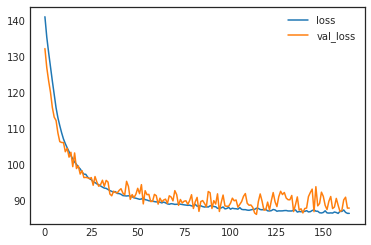

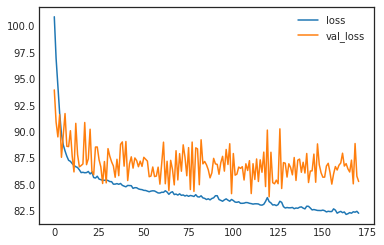

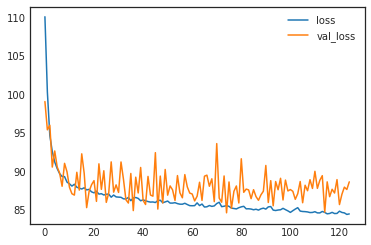

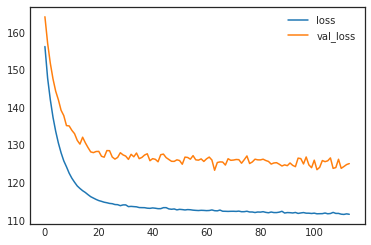

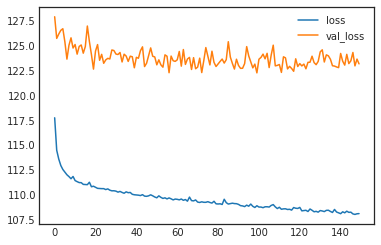

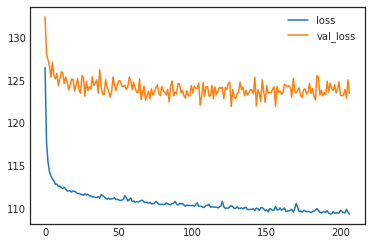

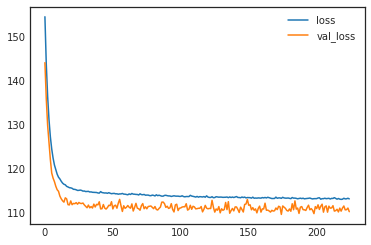

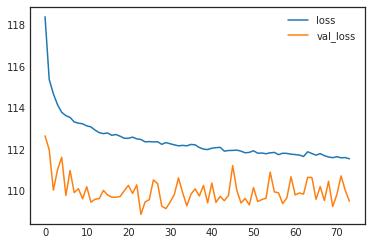

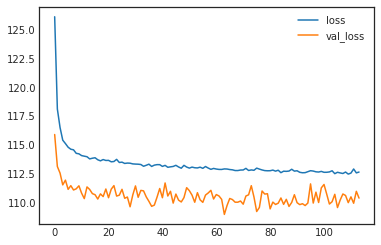

In [5]:
#min_prd_list = range(100, 676, 25)
# min_prd_list = [100, 160, 220, 280, 340, 400, 455, 510, 565, 620, 655]
min_prd_list = [100, 160, 220, 280, 340, 400]
#min_prd = min_prd_list[0]
windows_width = 3*12
cv_xgb_regularizer=0.2
optuna_xgb_trials = 40
optuna_nn_trials = 80

time0 = time.time()

results = pd.DataFrame(columns = ['min_prd', 'xgbf_train', 'xgbf_val', 'xgbf_test', 
                                  'xgbgs_train', 'xgbgs_val', 'xgbgs_test', 
                                  'xgbo_train', 'xgbo_val', 'xgbo_test',
                                  'nn2_train', 'nn2_val', 'nn2_test',
                                  'nn4_train', 'nn4_val', 'nn4_test',
                                 'nn6_train', 'nn6_val', 'nn6_test',
                                 'nn4opt_train', 'nn4opt_val', 'nn4opt_test',
                                 'nn6opt_train', 'nn6opt_val', 'nn6opt_test'])
results.min_prd = min_prd_list

for min_prd in min_prd_list:

    with open('../input/mleap-46-preprocessed/MLEAP_46_v7.pkl', 'rb') as pickled_one:
        df = pickle.load(pickled_one)
    df = df[df.prd.isin(range(min_prd-1, min_prd+windows_width+10))]
    df_cnt = df.count()
    empty_cols = list(df_cnt[df_cnt<int(df.shape[0]/2)].index)
    df.drop(columns=empty_cols, inplace=True)
    #display(df.shape, df.head(), df.year.describe(), df.count())

    features_miss_dummies = ['amhd', 'BAspr']
    for col in features_miss_dummies:
        if col in df.columns:
            df[col+'_miss'] = df[col].isnull().astype(int)

    temp_cols = ['PERMNO', 'year', 'prd']
    df.reset_index(inplace=True, drop=True)
    X = df.copy()
    y = X.pop('RET')

    train_indx = X.prd<(min_prd+windows_width-1)
    val_indx = X['prd'].isin(range(min_prd+windows_width-1, min_prd+windows_width+2))
    val_indx_extra = X['prd'].isin(range(min_prd+windows_width+5, min_prd+windows_width+8))
    test_indx = X['prd'].isin(range(min_prd+windows_width+2, min_prd+windows_width+5))

    X_train = X[train_indx]
    X_val = X[val_indx]
    X_val_extra = X[val_indx_extra]
    X_test = X[test_indx]
    y_train = y[train_indx]
    y_val = y[val_indx]
    y_val_extra = y[val_indx_extra]
    y_test = y[test_indx]

    #display(X_train.head(3), X_train.tail(3), y_train.head(3), y_train.tail(3))
    #display(X_train.prd.describe(), X_val.prd.describe(), X_test.prd.describe())
    display(X_train.shape, X_val.shape, X_test.shape)

    X_train.drop(columns=temp_cols, inplace=True)
    X_val.drop(columns=temp_cols, inplace=True)
    X_val_extra.drop(columns=temp_cols, inplace=True)
    X_test.drop(columns=temp_cols, inplace=True)

    #display(X_train.tail())
    col_cat = ['ind']
    col_num = [x for x in X_train.columns if x not in col_cat]
    for col in col_num:
        X_train[col] = X_train[col].fillna(X_train[col].median())
        X_val[col] = X_val[col].fillna(X_train[col].median())
        X_val_extra[col] = X_val_extra[col].fillna(X_train[col].median())
        X_test[col] = X_test[col].fillna(X_train[col].median())
    for col in col_cat:
        X_train[col] = X_train[col].fillna(value=-1000)
        X_val[col] = X_val[col].fillna(value=-1000)
        X_val_extra[col] = X_val_extra[col].fillna(value=-1000)
        X_test[col] = X_test[col].fillna(value=-1000)

    #display(X_train.tail())
    feature_transformer = ColumnTransformer([('num', StandardScaler(), col_num),
                                            ("cat", OneHotEncoder(sparse = False, handle_unknown="ignore", drop='if_binary'), col_cat)], 
                                            remainder="passthrough")

    print('Number of features before transformation: ', X_train.shape)
    train_index, val_index, val_index_extra, test_index = X_train.index, X_val.index, X_val_extra.index, X_test.index
    X_train = pd.DataFrame(feature_transformer.fit_transform(X_train), columns=feature_transformer.get_feature_names_out())
    X_val = pd.DataFrame(feature_transformer.transform(X_val), columns=feature_transformer.get_feature_names_out())
    X_val_extra = pd.DataFrame(feature_transformer.transform(X_val_extra), columns=feature_transformer.get_feature_names_out())
    X_test = pd.DataFrame(feature_transformer.transform(X_test), columns=feature_transformer.get_feature_names_out())
    print('time to do feature proprocessing: ')
    print('Number of features after transformation: ', X_train.shape, X_val.shape, X_val_extra.shape, X_test.shape)
    X_train.index = train_index
    X_val.index = val_index
    X_val_extra.index = val_index_extra
    X_test.index = test_index
    #display(X_train.tail())

    X = pd.concat([X_train, X_val])
    y = pd.concat([y_train, y_val])
    #display(X,y)

    X_ = pd.concat([X_train, X_val, X_val_extra])
    y_ = pd.concat([y_train, y_val, y_val_extra])
    #display(X,y, X_,y_)

    print('mae of a constant model', mean_absolute_error(df.RET, np.ones(df.shape[0])*(df.RET.mean())))
    print('R2 of a constant model', r2_score(df.RET, np.ones(df.shape[0])*(df.RET.mean())))

    xgb1 = XGBRegressor(tree_method = 'gpu_hist', n_estimators=400, max_depth=4, eta=0.02, colsample_bytree=0.4, subsample=0.6)
    xgb1.fit(X_train, y_train)
    print('fixed XGB train:', mean_absolute_error(y_train, xgb1.predict(X_train)), r2_score(y_train, xgb1.predict(X_train)))
    print('XGB val:', mean_absolute_error(y_val, xgb1.predict(X_val)), r2_score(y_val, xgb1.predict(X_val)))
    print('XGB val extra:', mean_absolute_error(y_val_extra, xgb1.predict(X_val_extra)), r2_score(y_val_extra, xgb1.predict(X_val_extra)))
    print('XGB test:', mean_absolute_error(y_test, xgb1.predict(X_test)), r2_score(y_test, xgb1.predict(X_test)))

    results.loc[results.min_prd==min_prd,'xgbf_train':'xgbf_test'] = \
    [r2_score(y_train, xgb1.predict(X_train)), 
    r2_score(y_val, xgb1.predict(X_val)),
    r2_score(y_test, xgb1.predict(X_test))]

    time1 = time.time()

    # Create a list where train data indices are -1 and validation data indices are 0
    split_index = [-1 if x in X_train.index else 0 for x in X.index]
    pds = PredefinedSplit(test_fold = split_index)

    xgb = XGBRegressor(tree_method = 'gpu_hist')
    param_grid = {'n_estimators':[400, 600, 800], 'max_depth':[2,3,4,5], 'eta':[0.006, 0.012, 0.02], 
                  'subsample':[0.6], 'colsample_bytree':[0.6]}
    xgbgs = GridSearchCV(estimator = xgb, cv=pds, param_grid=param_grid)

    # Fit with all data
    xgbgs.fit(X_, y_)

    print('gs XGB', xgbgs.best_params_, xgbgs.best_score_, time.time()-time1)
    print('XGB train:', mean_absolute_error(y_train, xgbgs.predict(X_train)), r2_score(y_train, xgbgs.predict(X_train)))
    print('XGB validation:', mean_absolute_error(y_val, xgbgs.predict(X_val)), r2_score(y_val, xgbgs.predict(X_val)))
    print('XGB validation extra:', mean_absolute_error(y_val_extra, xgbgs.predict(X_val_extra)), r2_score(y_val_extra, xgbgs.predict(X_val_extra)))
    print('XGB test:', mean_absolute_error(y_test, xgbgs.predict(X_test)), r2_score(y_test, xgbgs.predict(X_test)))

    results.loc[results.min_prd==min_prd,'xgbgs_train':'xgbgs_test'] = \
    [r2_score(y_train, xgbgs.predict(X_train)), 
    r2_score(y_val, xgbgs.predict(X_val)),
    r2_score(y_test, xgbgs.predict(X_test))]

    time1 = time.time()
    def objective_xgb(trial, cv_runs=1, n_splits=2, n_jobs=-1):

        params = {
        "tree_method": 'gpu_hist',
        "verbosity": 0,  # 0 (silent) - 3 (debug)
        "n_estimators": trial.suggest_int("n_estimators", 800, 1500),
        "max_depth": trial.suggest_int("max_depth", 2, 6),
        "learning_rate": trial.suggest_uniform("learning_rate", 0.0005, 0.03),
        "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.05, 0.95),
        "subsample": trial.suggest_uniform("subsample", 0.1, 0.95),
        "alpha": trial.suggest_loguniform("alpha", 0.1, 50.0),
        "lambda": trial.suggest_loguniform("lambda", 0.1, 500.0),
        "gamma": trial.suggest_loguniform("gamma", 1e-10, 100.0),
        "min_child_weight": trial.suggest_loguniform("min_child_weight", 0.1, 50)    }

        model = XGBRegressor(**params, njobs=-1)
        model.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=50, verbose = False)

        score_train = r2_score(y_train, model.predict(X_train))
        score_val = r2_score(y_val, model.predict(X_val))
        score_val_extra = r2_score(y_val_extra, model.predict(X_val_extra)) 
        score_val = (score_val+score_val_extra)/2
        overfit = np.abs(score_train-score_val)

        return score_val-cv_xgb_regularizer*overfit


    study = optuna.create_study(direction="maximize")
    study.optimize(objective_xgb, n_trials=optuna_xgb_trials)
    print('Total time for hypermarameter optimization, XGB: ', time.time()-time1)
    hp = study.best_params
    for key, value in hp.items():
        print(f"{key:>20s} : {value}")
    print(f"{'best objective value':>20s} : {study.best_value}")
    optuna_hyperpars = study.best_params
    optuna_hyperpars['tree_method']='gpu_hist'
    optuna_xgb = XGBRegressor(**optuna_hyperpars)
    optuna_xgb.fit(X, y)
    print('Optuna XGB train: \n', 
          mean_absolute_error(y_train, optuna_xgb.predict(X_train)), r2_score(y_train, optuna_xgb.predict(X_train)), '\nvalidation \n',
          mean_absolute_error(y_val, optuna_xgb.predict(X_val)), r2_score(y_val, optuna_xgb.predict(X_val)),
          mean_absolute_error(y_val_extra, optuna_xgb.predict(X_val_extra)), r2_score(y_val_extra, optuna_xgb.predict(X_val_extra)), '\ntest \n',
          mean_absolute_error(y_test, optuna_xgb.predict(X_test)), r2_score(y_test, optuna_xgb.predict(X_test)))

    results.loc[results.min_prd==min_prd,'xgbo_train':'xgbo_test'] = \
    [r2_score(y_train, optuna_xgb.predict(X_train)), 
    r2_score(y_val, optuna_xgb.predict(X_val)),
    r2_score(y_test, optuna_xgb.predict(X_test))]
    
    ###########
    ### NNs ###
    ###########
    
    neurons_base = 8
    l2_reg_rate = 0.5

    model_snn6 = Sequential([
        tf.keras.layers.Dense(units=neurons_base*4, activation="selu", kernel_initializer="lecun_normal", 
                              kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate), input_shape=X_train.shape[1:]),
        tf.keras.layers.Dense(units=neurons_base*2, activation="selu", kernel_initializer="lecun_normal",
                             kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate)),
        tf.keras.layers.Dense(units=neurons_base*2, activation="selu", kernel_initializer="lecun_normal",
                             kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate)),
        tf.keras.layers.Dense(units=neurons_base, activation="selu", kernel_initializer="lecun_normal",
                             kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate)),
        tf.keras.layers.Dense(units=neurons_base, activation="selu", kernel_initializer="lecun_normal",
                             kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate)),
        tf.keras.layers.Dense(units=neurons_base/2, activation="selu", kernel_initializer="lecun_normal",
                             kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate)),
        Dense(1)])

    print(model_snn6.count_params())

    early_stopping50 = EarlyStopping(patience=50, restore_best_weights=True)
    optimizer_adam = tf.keras.optimizers.Adam()

    model_snn6.compile(loss= "mean_squared_error" , optimizer=optimizer_adam, metrics=["mean_squared_error"])

    time1 = time.time()
    history = model_snn6.fit(X_train, y_train, validation_data=(X_val, y_val), 
                             batch_size=2048, epochs=1000, verbose=0, callbacks=[early_stopping50])
    history_df = pd.DataFrame(history.history)
    history_df.loc[:, ['loss', 'val_loss']].plot()
    print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()))

    results.loc[results.min_prd==min_prd,'nn6_train':'nn6_test'] = \
    [r2_score(y_train, model_snn6.predict(X_train)), 
    r2_score(y_val, model_snn6.predict(X_val)),
    r2_score(y_test, model_snn6.predict(X_test))]
    
    
    
    neurons_base = 8
    l2_reg_rate = 0.1

    model_snn2 = Sequential([
        tf.keras.layers.Dense(units=neurons_base*4, activation="selu", kernel_initializer="lecun_normal", 
                              kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate), input_shape=X_train.shape[1:]),
        tf.keras.layers.Dense(units=neurons_base, activation="selu", kernel_initializer="lecun_normal",
                             kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate)),
        Dense(1)])

    print(model_snn2.count_params())

    model_snn2.compile(loss= "mean_squared_error" , optimizer=optimizer_adam, metrics=["mean_squared_error"])

    time1 = time.time()
    history = model_snn2.fit(X_train, y_train, validation_data=(X_val, y_val), 
                             batch_size=2048, epochs=1000, verbose=0, callbacks=[early_stopping50])
    history_df = pd.DataFrame(history.history)
    history_df.loc[:, ['loss', 'val_loss']].plot()
    print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()))

    results.loc[results.min_prd==min_prd,'nn2_train':'nn2_test'] = \
    [r2_score(y_train, model_snn2.predict(X_train)), 
    r2_score(y_val, model_snn2.predict(X_val)),
    r2_score(y_test, model_snn2.predict(X_test))]
    
    
    neurons_base = 8
    l2_reg_rate = 0.3

    model_snn4 = Sequential([
        tf.keras.layers.Dense(units=neurons_base*4, activation="selu", kernel_initializer="lecun_normal", 
                              kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate), input_shape=X_train.shape[1:]),
        tf.keras.layers.Dense(units=neurons_base*2, activation="selu", kernel_initializer="lecun_normal",
                             kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate)),
        tf.keras.layers.Dense(units=neurons_base, activation="selu", kernel_initializer="lecun_normal",
                             kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate)),
        tf.keras.layers.Dense(units=neurons_base/2, activation="selu", kernel_initializer="lecun_normal",
                             kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate)),
        Dense(1)])

    print(model_snn4.count_params())

    time1 = time.time()
    model_snn4.compile(loss= "mean_squared_error" , optimizer=optimizer_adam, metrics=["mean_squared_error"])
    history = model_snn4.fit(X_train, y_train, validation_data=(X_val, y_val), 
                             batch_size=2048, epochs=1000, verbose=0, callbacks=[early_stopping50])
    history_df = pd.DataFrame(history.history)
    history_df.loc[:, ['loss', 'val_loss']].plot()
    print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()))

    results.loc[results.min_prd==min_prd,'nn4_train':'nn4_test'] = \
    [r2_score(y_train, model_snn4.predict(X_train)), 
    r2_score(y_val, model_snn4.predict(X_val)),
    r2_score(y_test, model_snn4.predict(X_test))]
    
    
    
    # try optuna, using this kaggle notebook: https://www.kaggle.com/code/mistag/keras-model-tuning-with-optuna

    time1 = time.time()
    study = optuna.create_study(direction="minimize", 
                                sampler=optuna.samplers.TPESampler(), 
                                pruner=optuna.pruners.HyperbandPruner())
    study.optimize(objective_nn4, n_trials=optuna_nn_trials)
    pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
    complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])
    temp = study.best_params
    display('Optuna NN4', study.best_params, time.time()-time1)

    optimal_hyperpars = list(temp.values())
    display(optimal_hyperpars)
    print('Time for hyperparameter optimization: ',time.time()-time1, optimal_hyperpars)

    optuna_nn = create_snnn4_model_hyperpars(neurons_base=optimal_hyperpars[0], 
                                             l2_reg_rate=optimal_hyperpars[1],
                                            l1_reg_rate=optimal_hyperpars[2])
    history = optuna_nn.fit(X_train, y_train, 
                            validation_data=(X_val, y_val),
                            batch_size=2048, 
                            epochs=1000,
                            verbose=0, 
                            callbacks=[early_stopping50])

    results.loc[results.min_prd==min_prd,'nn4opt_train':'nn4opt_test'] = \
    [r2_score(y_train, optuna_nn.predict(X_train)), 
    r2_score(y_val, optuna_nn.predict(X_val)),
    r2_score(y_test, optuna_nn.predict(X_test))]
    
    
    time1 = time.time()
    study = optuna.create_study(direction="minimize", 
                                sampler=optuna.samplers.TPESampler(), 
                                pruner=optuna.pruners.HyperbandPruner())
    study.optimize(objective_nn6, n_trials=optuna_nn_trials)
    pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
    complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])
    temp = study.best_params
    display('Optuna NN6', study.best_params, time.time()-time1)

    optimal_hyperpars = list(temp.values())
    display(optimal_hyperpars)
    print('Time for hyperparameter optimization: ', time.time()-time1, optimal_hyperpars)

    optuna_nn = create_snnn6_model_hyperpars(neurons_base=optimal_hyperpars[0], 
                                             l2_reg_rate=optimal_hyperpars[1],
                                            l1_reg_rate=optimal_hyperpars[2])
    history = optuna_nn.fit(X_train, y_train, 
                            validation_data=(X_val, y_val),
                            batch_size=2048, 
                            epochs=1000,
                            verbose=0, 
                            callbacks=[early_stopping50])

    results.loc[results.min_prd==min_prd,'nn6opt_train':'nn6opt_test'] = \
    [r2_score(y_train, optuna_nn.predict(X_train)), 
    r2_score(y_val, optuna_nn.predict(X_val)),
    r2_score(y_test, optuna_nn.predict(X_test))]
    
    
    
    display(results)
    
    results.to_csv('temp_models')
    
display(results)

In [6]:
temp

{'neurons_base': 16,
 'l2_regularizer': 0.026970846191440346,
 'l1_regularizer': 0.18104192814188844}

In [7]:
study.best_params

{'neurons_base': 16,
 'l2_regularizer': 0.026970846191440346,
 'l1_regularizer': 0.18104192814188844}

In [8]:
list(study.best_params.values())[1]

0.026970846191440346

In [9]:
display(results.iloc[:,1:].mean())
# cv_regularizer = 0.5
# optuna_trials = 80
print(time.time()-time0)

xgbf_train      0.121988
xgbf_val        0.042877
xgbf_test       0.019614
xgbgs_train     0.125665
xgbgs_val       0.102755
xgbgs_test      0.028949
xgbo_train      0.107692
xgbo_val        0.089299
xgbo_test       0.040421
nn2_train       0.104578
nn2_val         0.053508
nn2_test        0.013874
nn4_train       0.097565
nn4_val         0.057577
nn4_test        0.019508
nn6_train       0.090883
nn6_val         0.060193
nn6_test        0.022762
nn4opt_train    0.017476
nn4opt_val      0.019975
nn4opt_test     0.012920
nn6opt_train    0.032718
nn6opt_val      0.034556
nn6opt_test     0.029762
dtype: float64

3244.591541290283


In [10]:
# general point:
# compared to NN, xgb is harder to regularize
# in NN, you can simply shrink coefficient towards constant prediction.
# in xgb, you can not do that. the only way to regularize is via hyperparameters.
# in other words, by tweaking hyperpars, in NN you can approach R^2=0.0 prediction from a constant model arbitrarily close
# in xgb, you can not do that.
# by setting eta as low as 0.1% you can bring r2 down to 0.1%, but lowering eta further actyally increases abs(r2).


In [11]:
results

,min_prd,xgbf_train,xgbf_val,xgbf_test,xgbgs_train,xgbgs_val,xgbgs_test,xgbo_train,xgbo_val,xgbo_test,nn2_train,nn2_val,nn2_test,nn4_train,nn4_val,nn4_test,nn6_train,nn6_val,nn6_test,nn4opt_train,nn4opt_val,nn4opt_test,nn6opt_train,nn6opt_val,nn6opt_test
0,100,0.203674,0.035883,-0.01135,0.197144,0.113951,0.015671,0.192426,0.116482,0.0163,0.187214,0.050279,-0.026719,0.175113,0.053136,-0.0223,0.167318,0.063238,-0.013482,-0.0,-0.000984,-0.000895,-0.000001,-0.00097,-0.000882
1,160,0.092879,0.059218,0.019307,0.083546,0.104124,0.00178,0.069334,0.094531,0.043318,0.074393,0.067285,0.003229,0.068968,0.073971,0.014049,0.052757,0.072847,0.020005,0.052429,0.061237,0.040007,0.053314,0.065534,0.03404
2,220,0.069412,0.033529,0.050884,0.096305,0.09019,0.069395,0.061315,0.056884,0.061644,0.052126,0.042961,0.065112,0.048615,0.045624,0.066773,0.052574,0.044493,0.061762,-0.000001,-0.000327,-0.000351,0.044841,0.039103,0.056128


In [12]:
 
# def objective_nn(trial):
    
#     tf.keras.backend.clear_session()
    
#     with strategy.scope():
#         # Generate our trial model.
#         model = create_snnn_model(trial)

#         callbacks = [
#         tf.keras.callbacks.EarlyStopping(patience=40),
#         TFKerasPruningCallback(trial, "val_loss"),
#     ]

#         # Fit the model on the training data.
#         # The TFKerasPruningCallback checks for pruning condition every epoch.
        
#         history = model.fit(X_train, y_train, 
#                                 validation_data=(X_val, y_val),
#                                 batch_size=2048, 
#                                 epochs=500, 
#                                 verbose=1, 
#                                 callbacks=callbacks)

#         # Evaluate the model accuracy on the validation set.
#         score = model.evaluate(X_val, y_val, verbose=0)
#         return score[1]

# trials = 50

# study = optuna.create_study(direction="minimize", 
#                             sampler=optuna.samplers.TPESampler(), 
#                             pruner=optuna.pruners.HyperbandPruner())
# study.optimize(objective_nn, n_trials=trials)
# pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
# complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])
# temp = study.best_params
# display(study.best_params, time.time()-time1)

# optimal_hyperpars = list(temp.values())
# display(optimal_hyperpars)
# print(time.time()-time1, optimal_hyperpars)

# optuna_nn = create_snnn_model_hyperpars(neurons_base=optimal_hyperpars[0], l2_reg_rate=optimal_hyperpars[1])
# history = optuna_nn.fit(X_train, y_train, 
#                         validation_data=(X_val, y_val),
#                         batch_size=2048, 
#                         epochs=1000,
#                         verbose=1, 
#                         callbacks=[early_stopping50])

# results.loc[results.min_prd==min_prd,'nn4opt_train':'nn4opt_test'] = \
# [r2_score(y_train, optuna_nn.predict(X_train)), 
# r2_score(y_val, optuna_nn.predict(X_val)),
# r2_score(y_test, optuna_nn.predict(X_test))]

In [13]:
results.to_csv('temp_models')

In [14]:
# # try optuna for NN:

# def objective(trial):

#     n_layers = trial.suggest_int('n_layers', 1, 3)
#     model = tf.keras.Sequential()
#     for i in range(n_layers):
#         num_hidden = trial.suggest_int(f'n_units_l{i}', 4, 128, log=True)
#         model.add(tf.keras.layers.Dense(num_hidden, activation='relu'))
#     model.add(tf.keras.layers.Dense(1))
#     display(model.summary())
#     return accuracy

# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=10)


In [15]:
model_snn.summary()

NameError: name 'model_snn' is not defined

In [ ]:
# on nns:
# - try classic regularizers (l1, l2 etc)
# - try different architecture (not snnn)
# classic architecture:
# He initialization, elu activation, batch norm, l2 reg, adam.

# - try exotic architecture, e.g., wide'n'deep
# 


In [ ]:
# usually self-norm seems better: it overfits less and runs faster



In [ ]:
results